In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, pearsonr
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()


Saving babyNamesUSYOB-mostpopular.csv to babyNamesUSYOB-mostpopular.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving character.metadata.tsv to character.metadata.tsv


Baby Names Dataset Loaded: 224,261 rows, 5 columns
Character Dataset Loaded: 450,669 rows, 13 columns

Column count: 13

DATA CLEANING & PREPROCESSING
 Baby names cleaned: 6,917 unique names

 USING TEMPORAL ANALYSIS (Release dates available)
 Character data cleaned: 147,477 characters with valid dates
 Release year range: 1895 - 2016

Splitting compound character names
Split 147,477 characters into 256,592 individual names
Unique individual names: 54,335


 CREATING TEMPORAL INFLUENCE DATASET...
Processing 155,112 unique character name-year combinations
 Created influence dataset with 186,404 records
 Tracking 3,816 unique names



📊 DESCRIPTIVE STATISTICS

👶 BABY NAMES DATASET:
  • Total records: 224,261
  • Unique names: 6,917
  • Year range: 1880 - 2015
  • Total babies: 312,247,605

🎬 CHARACTER DATASET:
  • Total characters: 147,477
  • Individual names: 256,592
  • Unique names: 54,335
  • Release year range: 1895 - 2016

📈 INFLUENCE ANALYSIS:
  • Names analyzed: 3,816
  • Names 

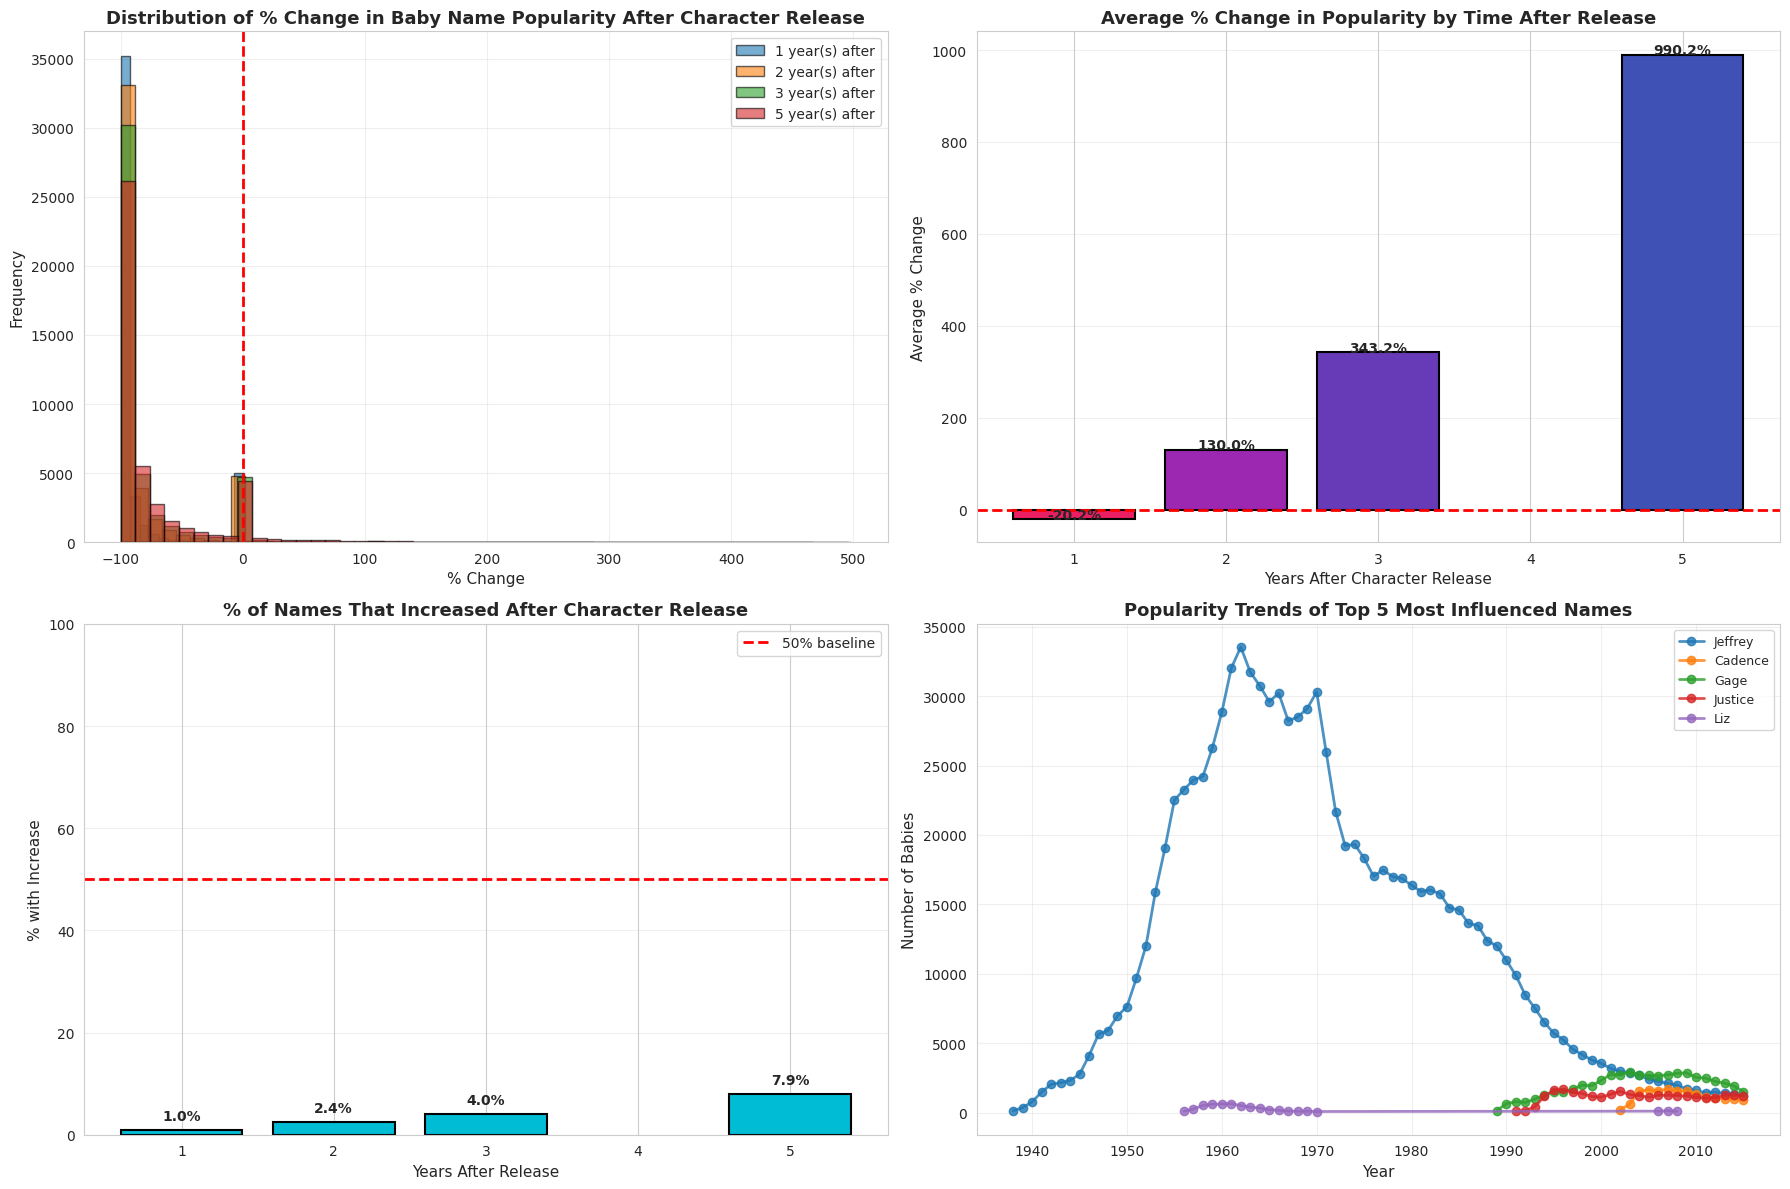

✅ Saved: case_study_examples.png


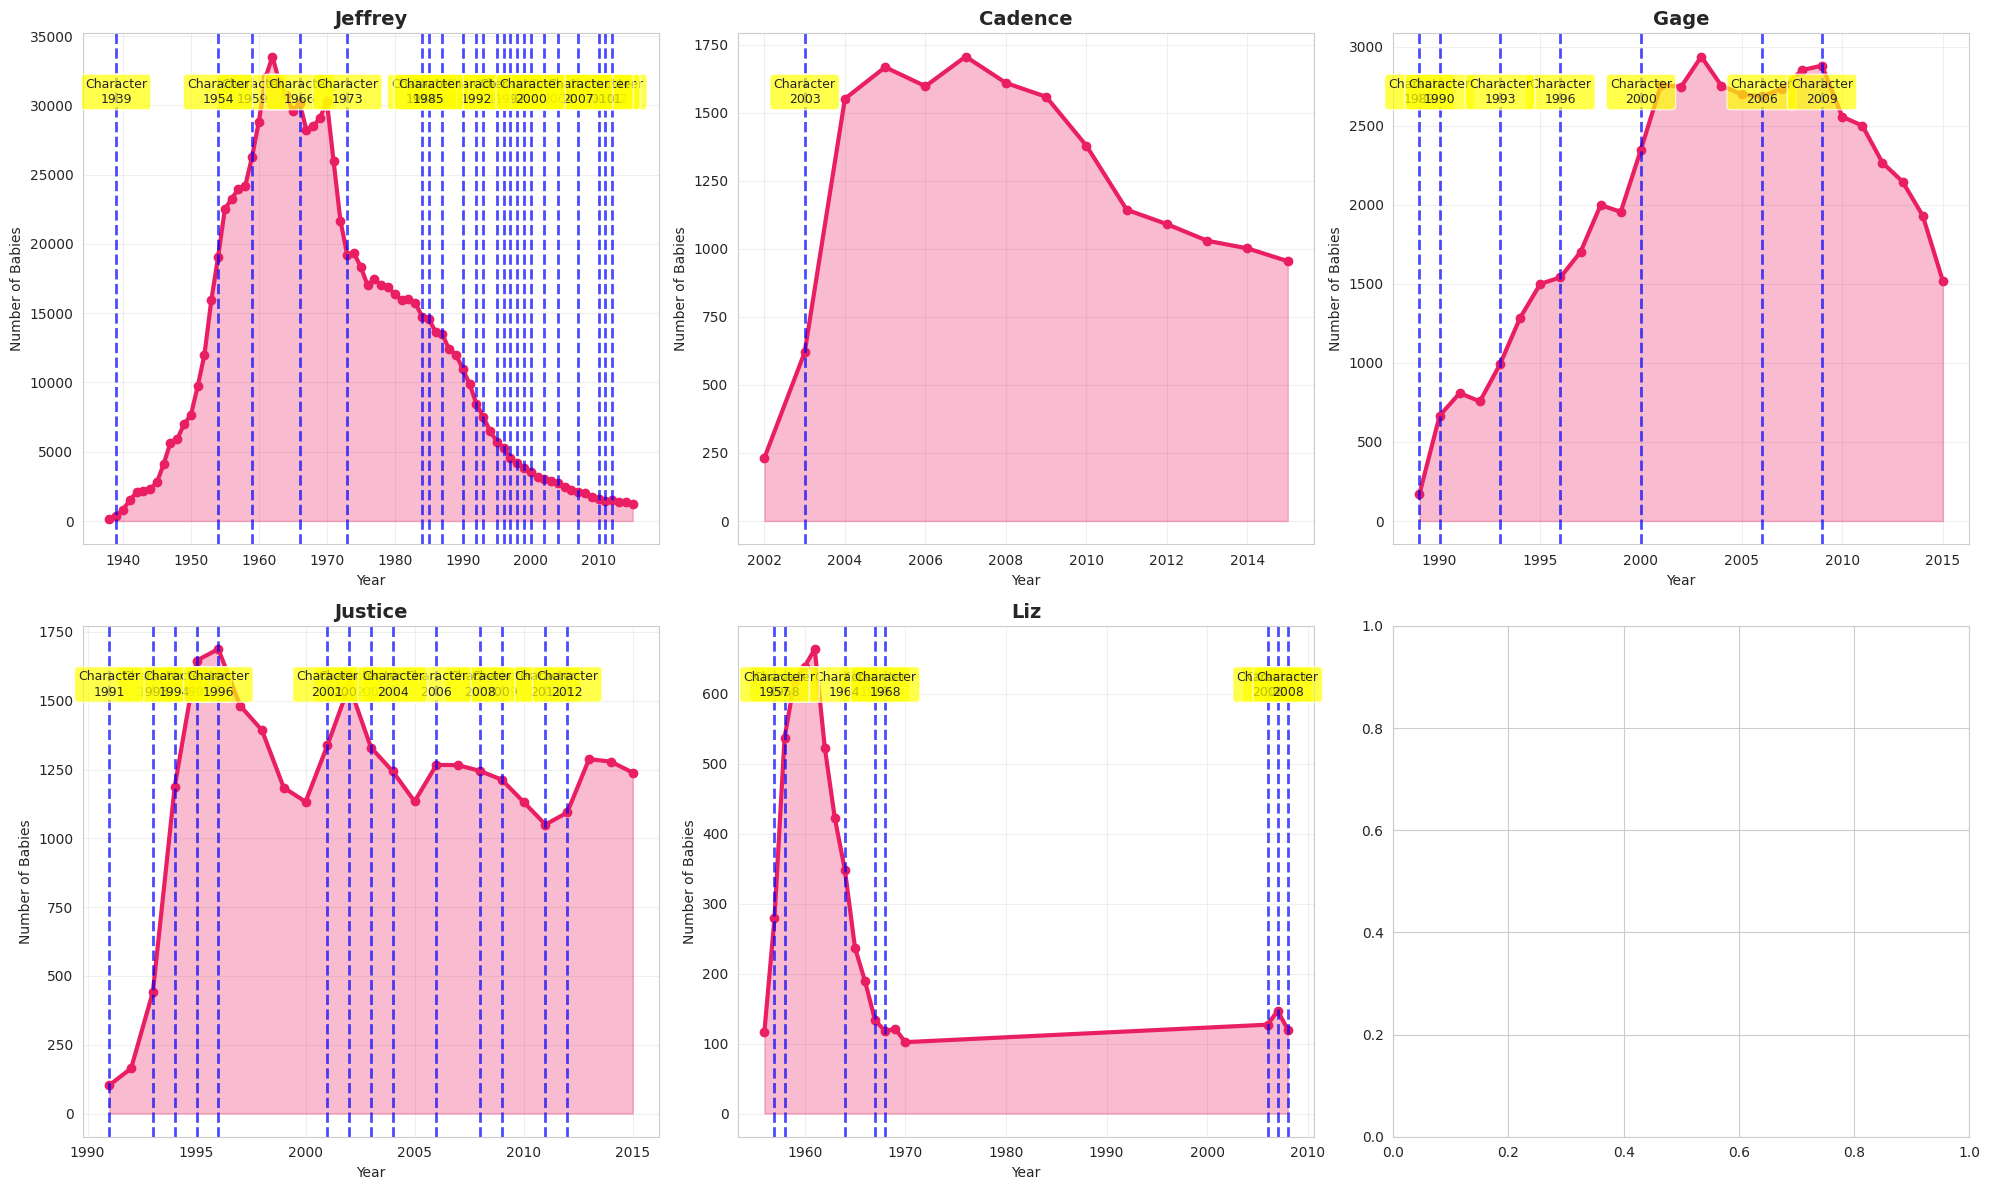




🔬 HYPOTHESIS TESTING

📋 RESEARCH HYPOTHESES:
H0 (Null): Character releases have NO effect on baby name popularity
H1 (Alternative): Character releases INCREASE baby name popularity

Significance Level: α = 0.05


TEST 1: One-Sample T-Test
Purpose: Test if average % change in popularity is significantly greater than 0

📊 1 Year(s) After Release:
  • Sample size: 46,601
  • Mean % change: -20.20%
  • Std dev: 992.01%
  • T-statistic: -4.3966
  • P-value: 0.999994
  ❌ FAIL TO REJECT null hypothesis

📊 3 Year(s) After Release:
  • Sample size: 46,601
  • Mean % change: 343.18%
  • Std dev: 4825.16%
  • T-statistic: 15.3533
  • P-value: 0.000000
  ✅ REJECT null hypothesis (p < 0.05)
     → Names show SIGNIFICANT increase after character release

📊 5 Year(s) After Release:
  • Sample size: 46,601
  • Mean % change: 990.24%
  • Std dev: 11344.99%
  • T-statistic: 18.8423
  • P-value: 0.000000
  ✅ REJECT null hypothesis (p < 0.05)
     → Names show SIGNIFICANT increase after character relea

In [4]:
# ============================================================================
# TEMPORAL INFLUENCE ANALYSIS: CHARACTER NAMES → BABY NAMES
# Analyzing whether movie/TV character names influence baby naming trends over time
# ============================================================================

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Load baby names dataset
df_babies = pd.read_csv("babyNamesUSYOB-mostpopular.csv")
print(f"Baby Names Dataset Loaded: {df_babies.shape[0]:,} rows, {df_babies.shape[1]} columns")

# Load character names dataset from TSV file
CHARACTER_FILE = "character.metadata.tsv"  # <-- CHANGE THIS to your file name

df_characters_raw = pd.read_csv(CHARACTER_FILE, sep="\t", header=None, low_memory=False)

df_characters_raw.columns = ['movie_id', 'movie_freebase_id', 'release_date', 'character_name',
                              'actor_dob', 'gender', 'height', 'ethnicity_id', 'actor_name', 'actor_age'] + \
                             [f'col_{i}' for i in range(10, len(df_characters_raw.columns))]

has_temporal_data = True

print(f"Character Dataset Loaded: {df_characters_raw.shape[0]:,} rows, {df_characters_raw.shape[1]} columns")
print(f"\nColumn count: {len(df_characters_raw.columns)}")

# STEP 3: DATA CLEANING & PREPROCESSING
# ============================================================================
print("\nDATA CLEANING & PREPROCESSING")
print("="*80)

# Clean baby names
df_babies['name_clean'] = df_babies['Name'].str.strip().str.title()
df_babies['year'] = df_babies['YearOfBirth']
print(f" Baby names cleaned: {df_babies['name_clean'].nunique():,} unique names")

# Clean character data
print("\n USING TEMPORAL ANALYSIS (Release dates available)")

df_characters = df_characters_raw[['release_date', 'character_name', 'gender']].copy()

# Convert release_date to datetime and extract year
df_characters['release_date'] = pd.to_datetime(df_characters['release_date'], errors='coerce')
df_characters['release_year'] = df_characters['release_date'].dt.year

# Remove rows with missing character names or release years
df_characters = df_characters.dropna(subset=['character_name', 'release_year'])
df_characters = df_characters[df_characters['character_name'].str.strip() != '']  # Remove empty names
df_characters['character_name_clean'] = df_characters['character_name'].str.strip().str.title()

print(f" Character data cleaned: {len(df_characters):,} characters with valid dates")
print(f" Release year range: {df_characters['release_year'].min():.0f} - {df_characters['release_year'].max():.0f}")

# Split compound character names
print("\nSplitting compound character names")
character_names_split = []
for idx, row in df_characters.iterrows():
    char_name = row['character_name_clean']
    release_year = row['release_year']
    gender = row['gender']

    if pd.notna(char_name) and len(char_name.strip()) > 0:
        individual_names = char_name.split()
        for name in individual_names:
            clean_name = ''.join(c for c in name if c.isalpha())
            if len(clean_name) > 1:
                character_names_split.append({
                    'original_character': char_name,
                    'individual_name': clean_name,
                    'release_year': release_year,
                    'gender': gender
                })

df_char_split = pd.DataFrame(character_names_split)
print(f"Split {len(df_characters):,} characters into {len(df_char_split):,} individual names")
print(f"Unique individual names: {df_char_split['individual_name'].nunique():,}")

# STEP 4: CREATE TEMPORAL MATCHING DATASET
# ============================================================================
print("\n\n CREATING TEMPORAL INFLUENCE DATASET...")
print("="*80)

# For each character name, find matching baby names and track them over time
influence_data = []

# Get unique character-year combinations
char_releases = df_char_split.groupby(['individual_name', 'release_year']).size().reset_index()
char_releases.columns = ['name', 'release_year', 'character_count']

print(f"Processing {len(char_releases):,} unique character name-year combinations")

# For each character name release
for idx, row in char_releases.iterrows():
    char_name = row['name']
    release_year = row['release_year']

    # Find baby name data for this name
    baby_data = df_babies[df_babies['name_clean'] == char_name].copy()

    if len(baby_data) > 0:
        # Calculate popularity before and after release
        before_release = baby_data[baby_data['year'] < release_year]['Number'].sum()

        # Look at different time windows after release
        for years_after in [1, 2, 3, 5]:
            after_release = baby_data[
                (baby_data['year'] >= release_year) &
                (baby_data['year'] < release_year + years_after)
            ]['Number'].sum()

            influence_data.append({
                'name': char_name,
                'release_year': release_year,
                'years_after': years_after,
                'before_count': before_release,
                'after_count': after_release,
                'character_count': row['character_count']
            })

df_influence = pd.DataFrame(influence_data)

if len(df_influence) > 0:
    # Calculate percentage change
    df_influence['pct_change'] = ((df_influence['after_count'] - df_influence['before_count']) /
                                   (df_influence['before_count'] + 1)) * 100
    df_influence['had_increase'] = df_influence['pct_change'] > 0

    print(f" Created influence dataset with {len(df_influence):,} records")
    print(f" Tracking {df_influence['name'].nunique():,} unique names")
else:
    print(" No matching names found between datasets")

print("\n" + "="*80)

# STEP 5: DESCRIPTIVE STATISTICS
# ============================================================================
print("\n\n📊 DESCRIPTIVE STATISTICS")
print("="*80)

print("\n👶 BABY NAMES DATASET:")
print(f"  • Total records: {len(df_babies):,}")
print(f"  • Unique names: {df_babies['name_clean'].nunique():,}")
print(f"  • Year range: {df_babies['year'].min()} - {df_babies['year'].max()}")
print(f"  • Total babies: {df_babies['Number'].sum():,}")

print("\n🎬 CHARACTER DATASET:")
print(f"  • Total characters: {len(df_characters):,}")
print(f"  • Individual names: {len(df_char_split):,}")
print(f"  • Unique names: {df_char_split['individual_name'].nunique():,}")
print(f"  • Release year range: {df_char_split['release_year'].min():.0f} - {df_char_split['release_year'].max():.0f}")

if len(df_influence) > 0:
    print("\n📈 INFLUENCE ANALYSIS:")
    print(f"  • Names analyzed: {df_influence['name'].nunique():,}")
    print(f"  • Names with increases after release: {df_influence[df_influence['had_increase']]['name'].nunique():,}")
    print(f"  • Average % change (1 year after): {df_influence[df_influence['years_after']==1]['pct_change'].mean():.2f}%")
    print(f"  • Average % change (3 years after): {df_influence[df_influence['years_after']==3]['pct_change'].mean():.2f}%")
    print(f"  • Average % change (5 years after): {df_influence[df_influence['years_after']==5]['pct_change'].mean():.2f}%")

print("\n" + "="*80)

# STEP 6: CASE STUDIES - TOP INFLUENCED NAMES
# ============================================================================
if len(df_influence) > 0:
    print("\n\n🌟 CASE STUDIES: TOP INFLUENCED NAMES")
    print("="*80)

    # Find names with biggest increases after character release
    df_3year = df_influence[df_influence['years_after'] == 3].copy()
    df_3year = df_3year[df_3year['before_count'] > 100]  # Only names with some prior popularity

    top_increases = df_3year.nlargest(20, 'pct_change')

    print("\n🚀 TOP 20 NAMES WITH BIGGEST INCREASES (3 years after character release):")
    print("\nName          Release Year  Before Count  After Count   % Change")
    print("-" * 75)
    for idx, row in top_increases.iterrows():
        print(f"{row['name']:<13} {row['release_year']:.0f}          {row['before_count']:>10,.0f}  {row['after_count']:>10,.0f}  {row['pct_change']:>8.1f}%")

    # Detailed case studies
    print("\n\n📖 DETAILED CASE STUDIES (Top 5):")
    print("="*80)

    for idx, row in top_increases.head(5).iterrows():
        name = row['name']
        release_year = int(row['release_year'])

        print(f"\n🎬 NAME: {name}")
        print(f"   Character Release Year: {release_year}")
        print(f"   Popularity before release: {row['before_count']:,.0f} babies")
        print(f"   Popularity 3 years after: {row['after_count']:,.0f} babies")
        print(f"   Percentage increase: {row['pct_change']:.1f}%")

        # Show year-by-year breakdown
        yearly_data = df_babies[df_babies['name_clean'] == name].copy()
        yearly_data = yearly_data[(yearly_data['year'] >= release_year - 3) &
                                  (yearly_data['year'] <= release_year + 5)]

        if len(yearly_data) > 0:
            print(f"   Year-by-year trend:")
            for _, year_row in yearly_data.groupby('year')['Number'].sum().items():
                marker = "📍" if _ == release_year else "  "
                print(f"     {marker} {_}: {year_row:>6,.0f} babies")

print("\n" + "="*80)

# STEP 7: VISUALIZATIONS
# ============================================================================
print("\n\n CREATING VISUALIZATIONS...")
print("="*80)

if len(df_influence) > 0:
    # Visualization 1: Distribution of percentage changes
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Distribution of % changes by time window
    for years in [1, 2, 3, 5]:
        data = df_influence[df_influence['years_after'] == years]['pct_change']
        data_filtered = data[(data > -100) & (data < 500)]  # Remove extreme outliers for visualization
        axes[0, 0].hist(data_filtered, bins=50, alpha=0.6, label=f'{years} year(s) after', edgecolor='black')

    axes[0, 0].set_title('Distribution of % Change in Baby Name Popularity After Character Release',
                         fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('% Change', fontsize=11)
    axes[0, 0].set_ylabel('Frequency', fontsize=11)
    axes[0, 0].legend()
    axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Average % change by time window
    avg_changes = df_influence.groupby('years_after')['pct_change'].mean()
    axes[0, 1].bar(avg_changes.index, avg_changes.values, color=['#E91E63', '#9C27B0', '#673AB7', '#3F51B5'],
                   edgecolor='black', linewidth=1.5)
    axes[0, 1].set_title('Average % Change in Popularity by Time After Release', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Years After Character Release', fontsize=11)
    axes[0, 1].set_ylabel('Average % Change', fontsize=11)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(avg_changes.values):
        axes[0, 1].text(avg_changes.index[i], v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

    # 3. Proportion with increases
    props = df_influence.groupby('years_after')['had_increase'].mean() * 100
    axes[1, 0].bar(props.index, props.values, color='#00BCD4', edgecolor='black', linewidth=1.5)
    axes[1, 0].set_title('% of Names That Increased After Character Release', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Years After Release', fontsize=11)
    axes[1, 0].set_ylabel('% with Increase', fontsize=11)
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% baseline')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].legend()
    for i, v in enumerate(props.values):
        axes[1, 0].text(props.index[i], v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

    # 4. Top names time series
    top_5_names = df_3year.nlargest(5, 'pct_change')['name'].values
    for name in top_5_names:
        name_data = df_babies[df_babies['name_clean'] == name].groupby('year')['Number'].sum()
        axes[1, 1].plot(name_data.index, name_data.values, marker='o', linewidth=2, label=name, alpha=0.8)

    axes[1, 1].set_title('Popularity Trends of Top 5 Most Influenced Names', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Year', fontsize=11)
    axes[1, 1].set_ylabel('Number of Babies', fontsize=11)
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('temporal_influence_overview.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: temporal_influence_overview.png")
    plt.show()

    # Visualization 2: Specific case study examples
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for idx, name in enumerate(top_5_names[:6]):
        # Get character release years for this name
        char_releases_name = df_char_split[df_char_split['individual_name'] == name]['release_year'].unique()

        # Get baby name data
        name_data = df_babies[df_babies['name_clean'] == name].groupby('year')['Number'].sum()

        axes[idx].plot(name_data.index, name_data.values, linewidth=3, color='#E91E63', marker='o')
        axes[idx].fill_between(name_data.index, name_data.values, alpha=0.3, color='#E91E63')

        # Mark character release years
        for rel_year in char_releases_name:
            if rel_year in name_data.index:
                axes[idx].axvline(x=rel_year, color='blue', linestyle='--', linewidth=2, alpha=0.7)
                axes[idx].text(rel_year, name_data.max() * 0.9, f'Character\n{int(rel_year)}',
                              ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

        axes[idx].set_title(f'{name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Year', fontsize=10)
        axes[idx].set_ylabel('Number of Babies', fontsize=10)
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('case_study_examples.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: case_study_examples.png")
    plt.show()

print("\n" + "="*80)

# STEP 8: HYPOTHESIS TESTING
# ============================================================================
print("\n\n🔬 HYPOTHESIS TESTING")
print("="*80)

if len(df_influence) > 0:
    print("\n📋 RESEARCH HYPOTHESES:")
    print("H0 (Null): Character releases have NO effect on baby name popularity")
    print("H1 (Alternative): Character releases INCREASE baby name popularity")
    print("\nSignificance Level: α = 0.05")

    # Test 1: One-sample t-test (is average % change > 0?)
    print("\n\n" + "="*80)
    print("TEST 1: One-Sample T-Test")
    print("="*80)
    print("Purpose: Test if average % change in popularity is significantly greater than 0")

    for years in [1, 3, 5]:
        data = df_influence[df_influence['years_after'] == years]['pct_change'].dropna()

        if len(data) > 30:
            t_stat, pvalue = stats.ttest_1samp(data, 0, alternative='greater')

            print(f"\n📊 {years} Year(s) After Release:")
            print(f"  • Sample size: {len(data):,}")
            print(f"  • Mean % change: {data.mean():.2f}%")
            print(f"  • Std dev: {data.std():.2f}%")
            print(f"  • T-statistic: {t_stat:.4f}")
            print(f"  • P-value: {pvalue:.6f}")

            if pvalue < 0.05:
                print(f"  ✅ REJECT null hypothesis (p < 0.05)")
                print(f"     → Names show SIGNIFICANT increase after character release")
            else:
                print(f"  ❌ FAIL TO REJECT null hypothesis")